In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import astropy.io.fits as fits

### Parte 1: Dados da observação

Carregando dados e obtendo os dados do header.

In [2]:
data = fits.getdata('galaxia.fits').astype(float)
head = fits.getheader('galaxia.fits')
head

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 1358 / Axis length                                    
NAXIS2  =                 1466 / Axis length                                    
EXTEND  =                    T / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2010-04-08T08:36:43' / Date FITS file was generated                  
IRAF-TLM= '2010-04-09T15:39:06' / Time of last modification                     
OBJECT  = 'NGC4579 '           / Name of the object observed                    
CREATOR = 'S18.7.0 '           / SW version used to create this FITS file       
TELESCOP= 'Spitzer '           / SPITZER Space Telescope                        
INSTRUME= 'IRAC    '        

In [3]:
print('Data de observação: ', head.get('DATE_OBS'))
print('Local de observação:', head.get('TELESCOP'))
print('Objeto observado:   ', obj:=head.get('OBJECT'))

Data de observação:  2004-06-09T08:25:31.222
Local de observação: Spitzer
Objeto observado:    NGC4579


### Parte 2: Encontrando o centroide do objeto

Selecionando um ponto da região onde o objeto está na imagem

In [4]:
#valores de x e y do objeto retirados do header
#utilizados apenas para obter um ponto da região
#a ser cortada
x0 = int(head.get('CRPIX1'))
y0 = int(head.get('CRPIX2'))
print(f'{x0=}, {y0=}')

x0=521, y0=969


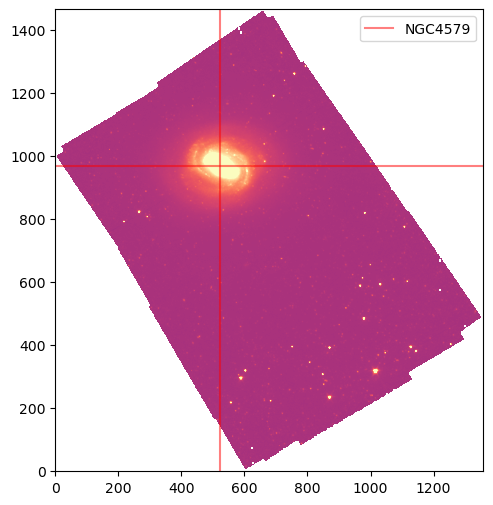

In [5]:
plt.figure(figsize=[6,6])
plt.imshow(data, cmap='magma', origin='lower', vmin=np.nanmean(data)-1.5*np.nanstd(data), vmax=np.nanmean(data)+1.5*np.nanstd(data))
plt.axvline(x0, color='r', alpha=0.5, label=obj)
plt.axhline(y0, color='r', alpha=0.5)
plt.legend()
plt.show()

In [6]:
def cut(data: np.ndarray, x0: int, y0: int , dx: int, dy: int) -> np.ndarray:
    '''função que faz um corte em uma imagem do tamanho 
       estipulado em (dx, dy) centrado em (x0, y0)'''
    return data[y0-dy//2:y0+dy//2, x0-dx//2:x0+dx//2]

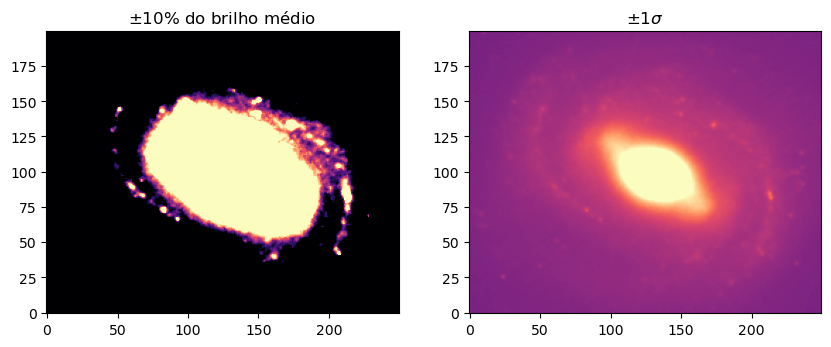

In [7]:
img = cut(data, x0, y0, 250, 200)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10,5])
ax1.imshow(img, cmap='magma', vmin=img.mean()*0.9, vmax=img.mean()*1.1, origin='lower')
ax1.set_title("$\pm 10\%$ do brilho médio")
ax2.imshow(img, cmap='magma', vmin=img.mean()-img.std(), vmax=img.mean()+img.std(), origin='lower')
ax2.set_title("$\pm 1 \sigma$")
plt.show()

In [8]:
def momento(data):
    """Função que calcula o centroide da imagem pelo método do momento"""
    #soma dos pixeis de cada coluna e linha
    Ii = np.nansum(data, axis=0)
    Ij = np.nansum(data, axis=1)
    #intensidade media dos pixeis das colunas e das linhas
    Ii_mean = np.sum(Ii)/len(Ii)
    Ij_mean = np.sum(Ij)/len(Ij)
    #indices de cada pixel
    xi = np.arange(data.shape[1])
    yj = np.arange(data.shape[0])
    #máscara de pixeis com intensidade maior que a intensidade media
    maski = Ii > Ii_mean
    maskj = Ij > Ij_mean
    #media ponderada
    xc = np.sum((Ii-Ii_mean)[maski]*xi[maski])/np.sum((Ii-Ii_mean)[maski])
    yc = np.sum((Ij-Ij_mean)[maskj]*yj[maskj])/np.sum((Ij-Ij_mean)[maskj])
    return xc, yc

xc=131.98694939429143, yc=98.13929704861008


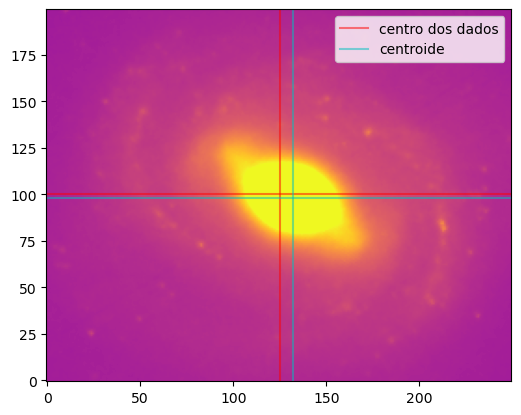

In [9]:
xc, yc = momento(img)
print(f"{xc=}, {yc=}")

plt.figure(figsize=[6,6])
plt.imshow(img, cmap='plasma', vmin=img.mean()-img.std(), vmax=img.mean()+img.std(), origin='lower')
plt.axvline(125, color='r', alpha=0.5, label='centro dos dados')
plt.axhline(100, color='r', alpha=0.5)
plt.axvline(xc, color='c', alpha=0.5, label='centroide')
plt.axhline(yc, color='c', alpha=0.5)
plt.legend()
plt.show()

### Parte 3: Ajustando uma gaussiana elíptica

In [10]:
def twoD_Gaussian(data, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    """Função que calcula uma gaussiana bi-dimensional"""
    x, y = data
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

Criando uma meshgrid para ajustar os valores.

In [11]:
y = np.arange(img.shape[0])
x = np.arange(img.shape[1])

x, y = np.meshgrid(x, y)

Usando a função curve_fit para ajustar os valores a gaussiana bi-dimensional e visualizando os parâmetros obtidos.

In [15]:
iniguess = (50, xc, yc, 10, 7.5, np.pi/10, 1) #chutes iniciais de parâmetros
par, cov = curve_fit(twoD_Gaussian, (x,y), img.ravel(), p0=iniguess)
nomes = ["amplitude", "x0", "y0", "sigma_x", "sigma_y", "theta", "offset"]
erros = np.sqrt(np.diagonal(cov))
print("Parâmetros:")
for i in range(len(nomes)):
    print(f"{nomes[i].rjust(len(nomes[0]))}: {par[i]:>18.14f} +- {erros[i]:.14f}")

Parâmetros:
amplitude: 120.15432677442453 +- 0.40395644134208
       x0: 131.69728561421456 +- 0.01044969092490
       y0:  98.05972645331964 +- 0.00930855008307
  sigma_x:   3.12210090740699 +- 0.01050296439451
  sigma_y:   2.75259966376940 +- 0.00925987691237
    theta:   0.20293337407501 +- 0.01882316467534
   offset:   0.98554814611294 +- 0.00665213609557


Visualizando o ajuste dos dados.

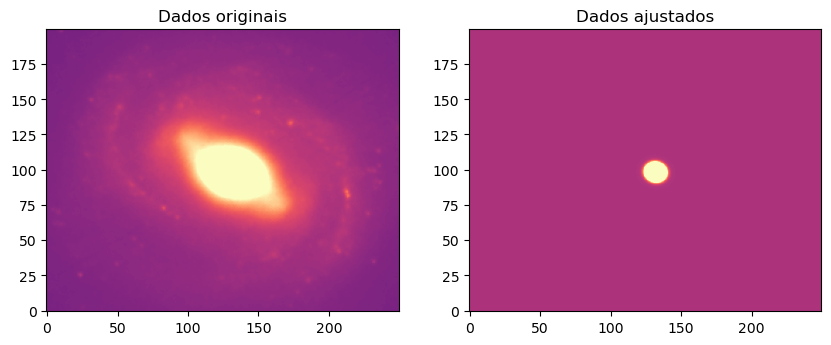

In [16]:
data_fit = twoD_Gaussian((x, y), *par)
img_fit = data_fit.reshape(img.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10,5])
ax1.imshow(img, origin='lower', vmin=img.mean()-img.std(), vmax=img.mean()+img.std(), cmap='magma')
ax1.set_title("Dados originais")
ax2.imshow(img_fit, origin='lower', vmin=img.mean()-img.std(), vmax=img.mean()+img.std(), cmap='magma')
ax2.set_title("Dados ajustados")
plt.show()

### Parte 4: Avaliando o resíduo

Calculamos o resíduo do ajuste e tentamos visualizar os braços espirais da galáxia.

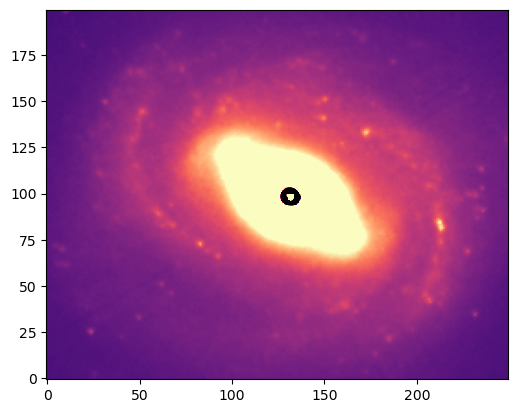

In [22]:
#calculando o resíduo
res = img-img_fit

#visualizando o resíduo
plt.imshow(res, vmin=res.mean()-res.std(), vmax=res.mean()+res.std(), origin='lower', cmap='magma')
plt.show()

Com este método, removemos a maior parte da região mais brilhante do centro da galáxia e parte do brilho superficial do restante. Sendo possível, assim, ver com clareza a barra e dois braços da galáxia.